In [1]:
import numpy as np
import pandas as pd
import math
import time
import random
import matplotlib.pyplot as plt

# Q2(a)

In [2]:
def entropy(data,main_data):  
    dcol=main_data.columns
    condition=data[data.columns[-1]]
    md_lc=main_data[main_data.columns[-1]]
    r=len(condition)
    condition_unique=pd.unique(md_lc)
    l=len(condition_unique)
    ans=0
    for i in range (0,l):
        g=condition[condition==condition_unique[i]]
        row=len(g)
        if row==0:
            e=0
        else:
            e=-(row/r)* math.log((row/r),2)
        ans=ans+e
    return ans

def best_split(data,main_data):  ## continuous features and discrete output
    r,_=data.shape
    dcol=data.columns
    bs_ec=[]
    max_infg_ec=[]
    condition_unique=pd.unique(main_data[dcol[-1]])
    array=[]
    for i in range (0,len(condition_unique)):
        rows,_=data[data[dcol[-1]]==condition_unique[i]].shape
        array.append(rows)
    zeros=0
    for i in range (0,len(array)):
        if array[i]==0:
            zeros=zeros+1
    
    if zeros!=len(array)-1:
        for i in range (0,len(dcol)-1):
            data_coli=data.loc[:,[dcol[i],dcol[-1]]]
            data_coli=data_coli.sort_values(dcol[i],ascending=True)
            coli_unique=pd.unique(data_coli[dcol[i]])
            coli_uni_avg=(coli_unique[1:]+coli_unique[:-1])/2
            info_gain=[0]
        
            for j in range (0,len(coli_uni_avg)):
                d1=data_coli[data_coli[dcol[i]]<=coli_uni_avg[j]]
                d2=data_coli[data_coli[dcol[i]]>coli_uni_avg[j]]
                r1,_=d1.shape
                r2,_=d2.shape
                infg=entropy(data,main_data)-(r1/r)*entropy(d1,main_data)-(r2/r)*entropy(d2,main_data)
                info_gain.append(infg)
            
            max_infg_index=info_gain.index(max(info_gain))-1
            bs_ec.append((dcol[i] ,coli_uni_avg[max_infg_index],array))
            max_infg_ec.append(info_gain[max_infg_index])
    
        max_ind=max_infg_ec.index(max(max_infg_ec))
        return bs_ec[max_ind]
    
    else:
        bs_ec.append(('no_split',0,array))
        return bs_ec[0]
        

def tree_learning(data,depth,main_data):
        bs=best_split(data,main_data)
        t=dict()
        if depth>0 and bs[0]!='no_split':
            depth=depth-1
            ln=data[data[bs[0]]<=bs[1]]
            rn=data[data[bs[0]]>bs[1]]
            t['l']=tree_learning(ln,depth,main_data)
            t['r']=tree_learning(rn,depth,main_data)
            return [bs,t]
        else:
            return [(['no_split'],0,bs[2]),{}]

In [3]:
def mse(data):                   ## continuous features and continuous output 
    c=data[data.columns[-1]]
    mean=c.describe()['mean']
    r=len(c)
    err=0
    for i in range (0,r):
        w=(mean-c[i])**2
        err=err+w
    mse=err/r
    return mse


def best_split_regressor(data,main_data):
    r=len(data)
    dcol=main_data.columns
    bs_ec=[]
    min_mse_ec=[]
    mean=data[data.columns[-1]].describe()['mean']
    
    if r>1:    
        for i in range (0,len(dcol)-1):
            data_coli=data.loc[:,[dcol[i],dcol[-1]]]
            data_coli=data_coli.sort_values(dcol[i],ascending=True)
            coli_unique=pd.unique(data_coli[dcol[i]])
            coli_uni_avg=(coli_unique[1:]+coli_unique[:-1])/2
            mean_se=[0]
            
            for j in range (0,len(coli_uni_avg)):
                d1=data_coli[data_coli[dcol[i]]<=coli_uni_avg[j]].reset_index(drop=True)
                d2=data_coli[data_coli[dcol[i]]>coli_uni_avg[j]].reset_index(drop=True)
                r1=len(d1)
                r2=len(d2)
                s=mse(d1)+mse(d2)
                mean_se.append(s)
                
            min_mse_index=mean_se.index(min(mean_se))-1
            bs_ec.append((dcol[i] ,coli_uni_avg[min_mse_index],mean))
            min_mse_ec.append(mean_se[min_mse_index])
    
        min_ind=min_mse_ec.index(min(min_mse_ec))
        return bs_ec[min_ind]
                
    else:
        bs_ec.append(('no_split',0,mean))
        return bs_ec[0]


def tree_learning_regressor(data,depth,main_data):
        bs=best_split_regressor(data,main_data)
        t=dict()
        if depth>0 and bs[0]!='no_split':
            depth=depth-1
            ln=data[data[bs[0]]<=bs[1]].reset_index(drop=True)
            rn=data[data[bs[0]]>bs[1]].reset_index(drop=True)
            t['l']=tree_learning_regressor(ln,depth,main_data)
            t['r']=tree_learning_regressor(rn,depth,main_data)
            return [bs,t]
        else:
            return [(['no_split'],0,bs[2]),{}]
        

# Q2(b)

In [4]:
def testing(test_row,model):
    a=model[0]
    dic=model[1]
    if a[0]== ['no_split']:
        return a[2].index(max(a[2]))
    else:
        if test_row[a[0]]<a[1]:
            return testing(test_row,dic['l'])
        else :
            return testing(test_row,dic['r'])

def prediction(test_data,model):
    r=len(test_data)
    predictions=[]
    for i in range (0,r):
        test_row=test_data.iloc[i]       
        pred=testing(test_row,model)
        predictions.append(pred)
    return predictions

def accuracy (test_data,predictions,train_data):
    c=0
    ic=0
    dcol=test_data.columns
    r,_=test_data.shape
    gt=test_data[test_data.columns[-1]]
    #analog=['Iris-setosa','Iris-versicolor','Iris-virginica']
    analog=pd.unique(train_data['iris'])
    for i in range (0,r):
        if analog[int(predictions[i])]==gt.iloc[i]:
            c=c+1
        else:
            ic=ic+1
    accuracy=(c/r)*100
    return accuracy 

        

In [21]:
data1=pd.read_csv('iris_dataset.csv')

iris_dataset=data1.loc[:,['sepal length','sepal width','petal length','petal width','iris']]
iris_dataset.columns=['sepal_length','sepal_width','petal_length','petal_width','iris']


shuf=iris_dataset.sample(frac=1).reset_index(drop=True)


def divide_data(data,train_percent):
    r,_=data.shape
    dr=int(r*(train_percent/100))
    train_data=data[:dr]
    test_data=data[dr:]
    return (train_data,test_data)

(tr_d,test_d)=divide_data(shuf,70)

model= tree_learning(tr_d,4,tr_d)
print(model)
pred_set=prediction(test_d,model)
print(accuracy(test_d,pred_set,tr_d))    


[('petal_length', 2.45, [33, 38, 34]), {'l': [(['no_split'], 0, [33, 0, 0]), {}], 'r': [('petal_width', 1.75, [0, 38, 34]), {'l': [('petal_length', 4.95, [0, 38, 5]), {'l': [('petal_width', 1.65, [0, 36, 1]), {'l': [(['no_split'], 0, [0, 36, 0]), {}], 'r': [(['no_split'], 0, [0, 0, 1]), {}]}], 'r': [('sepal_width', 2.6500000000000004, [0, 2, 4]), {'l': [(['no_split'], 0, [0, 0, 2]), {}], 'r': [(['no_split'], 0, [0, 2, 2]), {}]}]}], 'r': [(['no_split'], 0, [0, 0, 29]), {}]}]}]
97.77777777777777


# Q2(c)

In [13]:
# 5 FOLD CROSS VALIDATION
main_data=shuf
r=len(main_data)
k=5
r_ds=int(r/k)
datasets=np.array([None]*k)
for i in range (0,k):
    datasets[i]=main_data.loc[i*r_ds:(i+1)*r_ds]
    if i==4:
        datasets[i]=main_data.loc[i*r_ds:]

for j in range (0,k):
    d_f=np.roll(datasets,j)
    d_f[0]=pd.DataFrame(d_f[0])
    d_f[1]=pd.DataFrame(d_f[1])
    d_f[2]=pd.DataFrame(d_f[2])
    train_d=pd.concat([d_f[0],d_f[1],d_f[2]])
    val_d=pd.DataFrame(d_f[3])
    te_d=pd.DataFrame(d_f[4])
    depth_accu=np.zeros((9,2))

    for depth in range (0,9):
        model= tree_learning(train_d,depth+1,train_d)
        pred_set=prediction(val_d,model)
        accu=accuracy(val_d,pred_set,train_d)
        depth_accu[depth,0]=depth+1
        depth_accu[depth,1]=accu
    print(depth_accu)
        
    




[[ 1.         54.83870968]
 [ 2.         90.32258065]
 [ 3.         96.77419355]
 [ 4.         90.32258065]
 [ 5.         90.32258065]
 [ 6.         90.32258065]
 [ 7.         90.32258065]
 [ 8.         90.32258065]
 [ 9.         90.32258065]]


IndexError: index -1 is out of bounds for axis 0 with size 0

# Q3

In [9]:
r_est_price1=pd.read_excel('Real_estate_valuation_data_set.xlsx')
r_est_price=r_est_price1.loc[:,['X1 transaction date', 'X2 house age',
       'X3 distance to the nearest MRT station',
       'X4 number of convenience stores', 'X5 latitude', 'X6 longitude',
       'Y house price of unit area']]
r_est_price.columns=['X1', 'X2',
       'X3',
       'X4', 'X5', 'X6',
       'Y']

In [10]:
def testing_regressor(test_row,model):
    a=model[0]
    dic=model[1]
    if a[0]== ['no_split']:
        return a[2]
    else:
        if test_row[a[0]]<a[1]:
            return testing_regressor(test_row,dic['l'])
        else :
            return testing_regressor(test_row,dic['r'])

def prediction_regressor(test_data,model):
    r=len(test_data)
    predictions=[]
    for i in range (0,r):
        test_row=test_data.iloc[i]       
        pred=testing_regressor(test_row,model)
        predictions.append(pred)
    return predictions

def accuracy_regressor(test_data,predictions):
    dcol=test_data.columns
    r,_=test_data.shape
    gt=test_data[test_data.columns[-1]]
    
    se=0
    for i in range (0,r):
        k=(predictions[i]-gt[i])**2
        se=se+k
    mse=se/r
    rmse=math.sqrt(mse)
    return rmse



In [12]:
shuf_reg=r_est_price.sample(frac=1).reset_index(drop=True)


def divide_data(data,train_percent):
    r,_=data.shape
    dr=int(r*(train_percent/100))
    train_data=data[:dr].reset_index(drop=True)
    test_data=data[dr:].reset_index(drop=True)
    return (train_data,test_data)

(tr_d,test_d)=divide_data(shuf_reg,70)

model=tree_learning_regressor(tr_d,3,tr_d)
pred_set_reg=prediction_regressor(test_d,model)
print(accuracy_regressor(test_d,pred_set_reg))


14.672397042836579


# Q4

In [444]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split


data = pd.read_excel('Real_estate_valuation_data_set.xlsx')
data.describe()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,207.500000,2013.148953,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193
std,119.655756,0.281995,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488
min,1.000000,2012.666667,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,104.250000,2012.916667,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,207.500000,2013.166667,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,310.750000,2013.416667,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,414.000000,2013.583333,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


In [445]:
columns = ["X2 house age","X3 distance to the nearest MRT station","X4 number of convenience stores","X5 latitude","X6 longitude"]
data_features = data[columns]
y = data["Y house price of unit area"]

In [446]:
train_x,test_x,train_y,test_y = train_test_split(data,y,random_state= 564)

In [447]:
model = DecisionTreeRegressor()
model.fit(train_x,train_y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [448]:
predicted = model.predict(test_x)
test_y=test_y.reset_index(drop=True)

In [450]:
root_mean_se=0
for i in range (0,len(predicted)):
    k=(predicted[i]-test_y[i])**2
    root_mean_se=root_mean_se+k
    
print(math.sqrt(root_mean_se/len(predicted)))

1.1203965644085405


Compared to the one executed from scratch in which the root mean square error is 12.5, the decision tree made from scikitlearn performs way better with root mean square error of 1.12

# Q6

In [435]:
data1=pd.read_csv('iris_dataset.csv')

iris_dataset=data1.loc[:,['sepal length','sepal width','petal length','petal width','iris']]
iris_dataset.columns=['sepal_length','sepal_width','petal_length','petal_width','iris']


shuf=iris_dataset.sample(frac=1).reset_index(drop=True)


def divide_data(data,train_percent):
    r,_=data.shape
    dr=int(r*(train_percent/100))
    train_data=data[:dr]
    test_data=data[dr:]
    return (train_data,test_data)

(tr_d,test_d)=divide_data(shuf,70)

worst_model= tree_learning(tr_d,1,tr_d)  ##depth=1
pred_set=prediction(tr_d,worst_model)
print(('worst model accuracy',accuracy(tr_d,pred_set,tr_d)))    

best_model= tree_learning(tr_d,5,tr_d)  ##depth=1
pred_set=prediction(tr_d,best_model)
print(('best model accuracy',accuracy(tr_d,pred_set,tr_d)))    


('worst model accuracy', 67.61904761904762)
('best model accuracy', 100.0)


# Q7

In [441]:
def tree_learning(data,depth,main_data):
        bs=best_split(data,main_data)
        t=dict()
        if depth>0 and bs[0]!='no_split':
            depth=depth-1
            ln=data[data[bs[0]]<=bs[1]]
            rn=data[data[bs[0]]>bs[1]]
            t['l']=tree_learning(ln,depth,main_data)
            t['r']=tree_learning(rn,depth,main_data)
            return [bs,t]
        else:
            return [(['no_split'],0,bs[2]),{}]
def data_random(N,M):
    data = np.random.rand(N,M)
    y_label = []
    for i in range(N):
        y_label.append(random.choice([0,1]))
    data = pd.DataFrame(data)
    data["label"] = pd.Series(y_label)
    return data

In [442]:
data_random(2,3)

,0,1,2,label
0,0.760718,0.464340,0.881708,0
1,0.103946,0.062973,0.006612,1


In [453]:
trainingTimes = []
predictingTimes = []
for j in range(50,200):
    TRAIN_DATA, TEST_DATA = train_test_split(data_random(j,5), test_size=0.3,random_state = 42)
    learning_start=time.time()
    model=tree_learning(TRAIN_DATA,2,TRAIN_DATA)
    learning_stop=time.time()
    learning_time=learning_stop-learning_start
    
    predict_time_start=time.time()
    pred=prediction(TEST_DATA,model)
    predict_time_stop=time.time()
    predict_time=predict_time_stop-predict_time_start
    
    
    trainingTimes.append(learning_time)
    predictingTimes.append(predict_time)
    
    

NOTE: THIS CODE IS TAKING A LONG TIME TO RUN. I KINDLY REQUEST TO PLEASE TAKE A LOOK AT THE ALGORITHM.

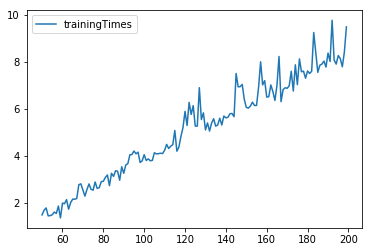

In [454]:
XLabel = range(50,200)
plt.plot(XLabel , trainingTimes)
plt.legend(['trainingTimes'])
plt.show()

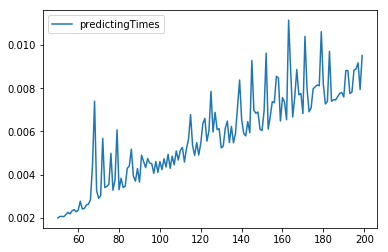

In [455]:
plt.plot(XLabel, predictingTimes)
plt.legend(['predictingTimes'])
plt.show()